### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 2nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [40]:

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import emcee
import corner
import random
import dynesty
from dynesty import plotting as dyplot
%matplotlib inline


In [23]:
#/Users/mcgowkb1/ASTR8070/repos/astr_8070_s24/lectures/coursework/homeworks/hw_data/

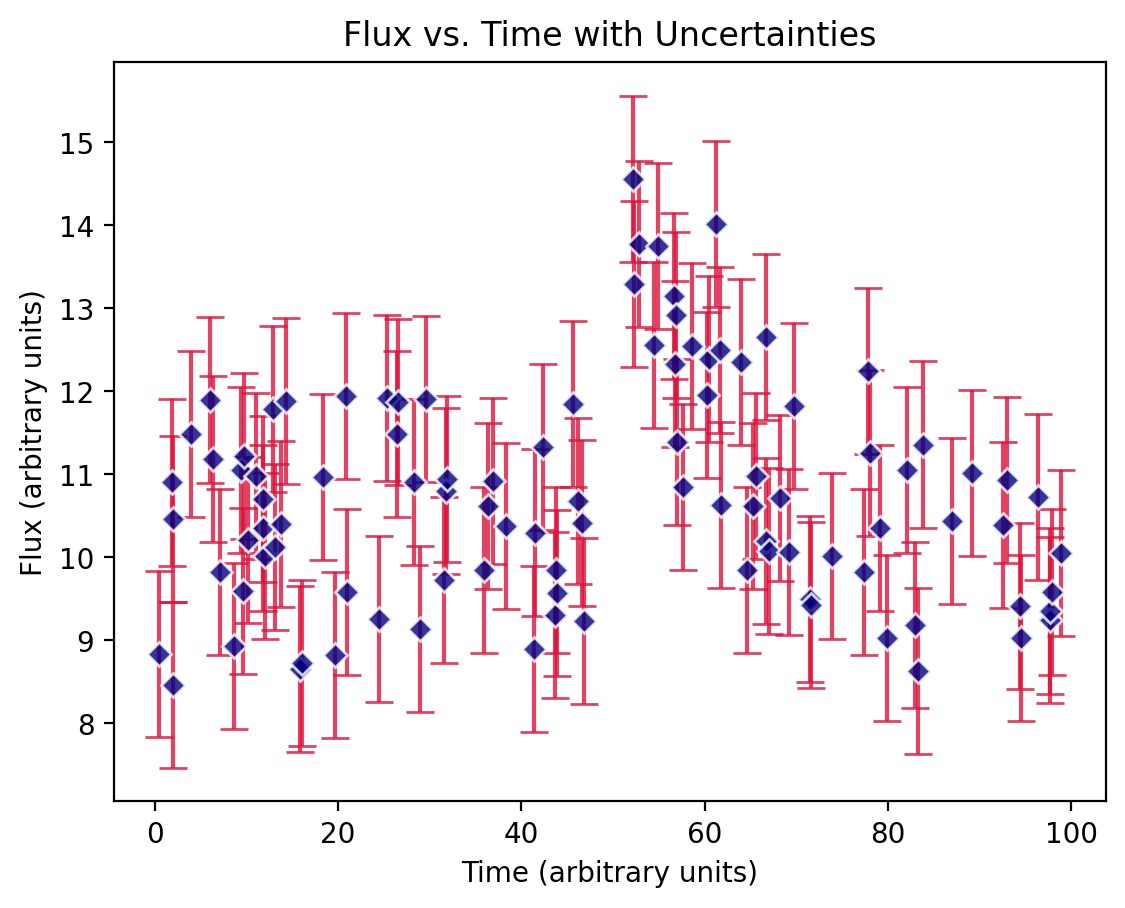

In [24]:
# Load the data from hw5_data_1.npy
data = np.load('/Users/mcgowkb1/ASTR8070/repos/astr_8070_s24/coursework/homeworks/hw_data/hw5_data_1.npy')

time = data[:, 0]
flux = data[:, 1]
uncertainties = data[:, 2]

# Plot data w/ uncertainties
plt.errorbar(time, flux, yerr=uncertainties, fmt='D', color='navy',markeredgecolor='white', ecolor='crimson', alpha = 0.8,capsize=5)
plt.xlabel('Time (arbitrary units)')
plt.ylabel('Flux (arbitrary units)')
plt.title('Flux vs. Time with Uncertainties')
plt.show()


In [25]:
# Sharp burst with an exponential tail model
# returns flucx 
# t = time array
# b = background amplitude
# a = burst amplitude
# alpha = decay rate of burst
# t_0 = epoch of burst

def burst_model(t, b, A, alpha, t_0):
    y = np.empty_like(t) #similar shape
    y[t < t_0] = b
    y[t >= t_0] = b + A * np.exp(-alpha * (t[t >= t_0] - t_0))
    return y
# Likelihood for burst model, returns negative log-likelihood  
def likelihood_burst(params, t, flux, uncertainties):
    b, A, alpha, t_0 = params
    model_flux = burst_model(t, b, A, alpha, t_0)
    chi_squared = np.sum(((flux - model_flux) / uncertainties) ** 2)
    return 0.5 * chi_squared + 0.5 * np.sum(np.log(2 * np.pi * uncertainties ** 2))

# Init guess 
initial_guess = [np.mean(flux), np.max(flux) - np.mean(flux), 0.5, np.median(time)]

# Minimize the negative log-likelihood to fit the burst model to the data
result = minimize(likelihood_burst, initial_guess, args=(time, flux, uncertainties))

best_params = result.x
print("Best-fit parameters:", best_params)


Best-fit parameters: [10.52874313  3.26120852  0.07164048 46.20152001]


In [26]:
# Want bayseian analysis that recovers MCMC chain posterior probability

# Def log prior
def log_prior(params):
    b, A, t0, ln_alpha = params
    if 0 < b < 50 and 0 < A < 50 and 0 < t0 < 100 and -5 < ln_alpha < 5:
        return 0.0
    return -np.inf

# Def log likelihood (same as before)
def log_likelihood(params, t, flux, uncertainties):
    b, A, t0, ln_alpha = params
    alpha = np.exp(ln_alpha)
    model_flux = burst_model(t, b, A, alpha, t0)
    chi_squared = np.sum(((flux - model_flux) / uncertainties) ** 2)
    return -0.5 * chi_squared

# Def log posterior
def log_posterior(params, t, flux, uncertainties):
    return log_prior(params) + log_likelihood(params, t, flux, uncertainties)


SRT: Burst model is great! Your log likelihood function is mostly fine, but the reliance on the chi-squared and ignoring the pre-factors to the Gaussian likelihood might come back to bite you when the evidence calculation is being done below.

In [27]:
# Init guess for the parameters
initial_guess = [np.mean(flux), np.max(flux) - np.mean(flux), np.median(time), 0.0]

# Numb of walkers & steps
nwalkers = 100
ndim = len(initial_guess)
nsteps = 10000

# Init walkers
p0 = [initial_guess + 1e-4*np.random.randn(ndim) for _ in range(nwalkers)]

# Init MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(time, flux, uncertainties))

# Run MCMC
sampler.run_mcmc(p0, nsteps)# progress=True

# Get the chain and flatten it
samples = sampler.get_chain(discard=100, flat=True)


In [28]:
# Burn-in
burnin = 1000
emcee_trace = sampler.chain[:, burnin:, :].reshape(-1, ndim)

#print("done")


done


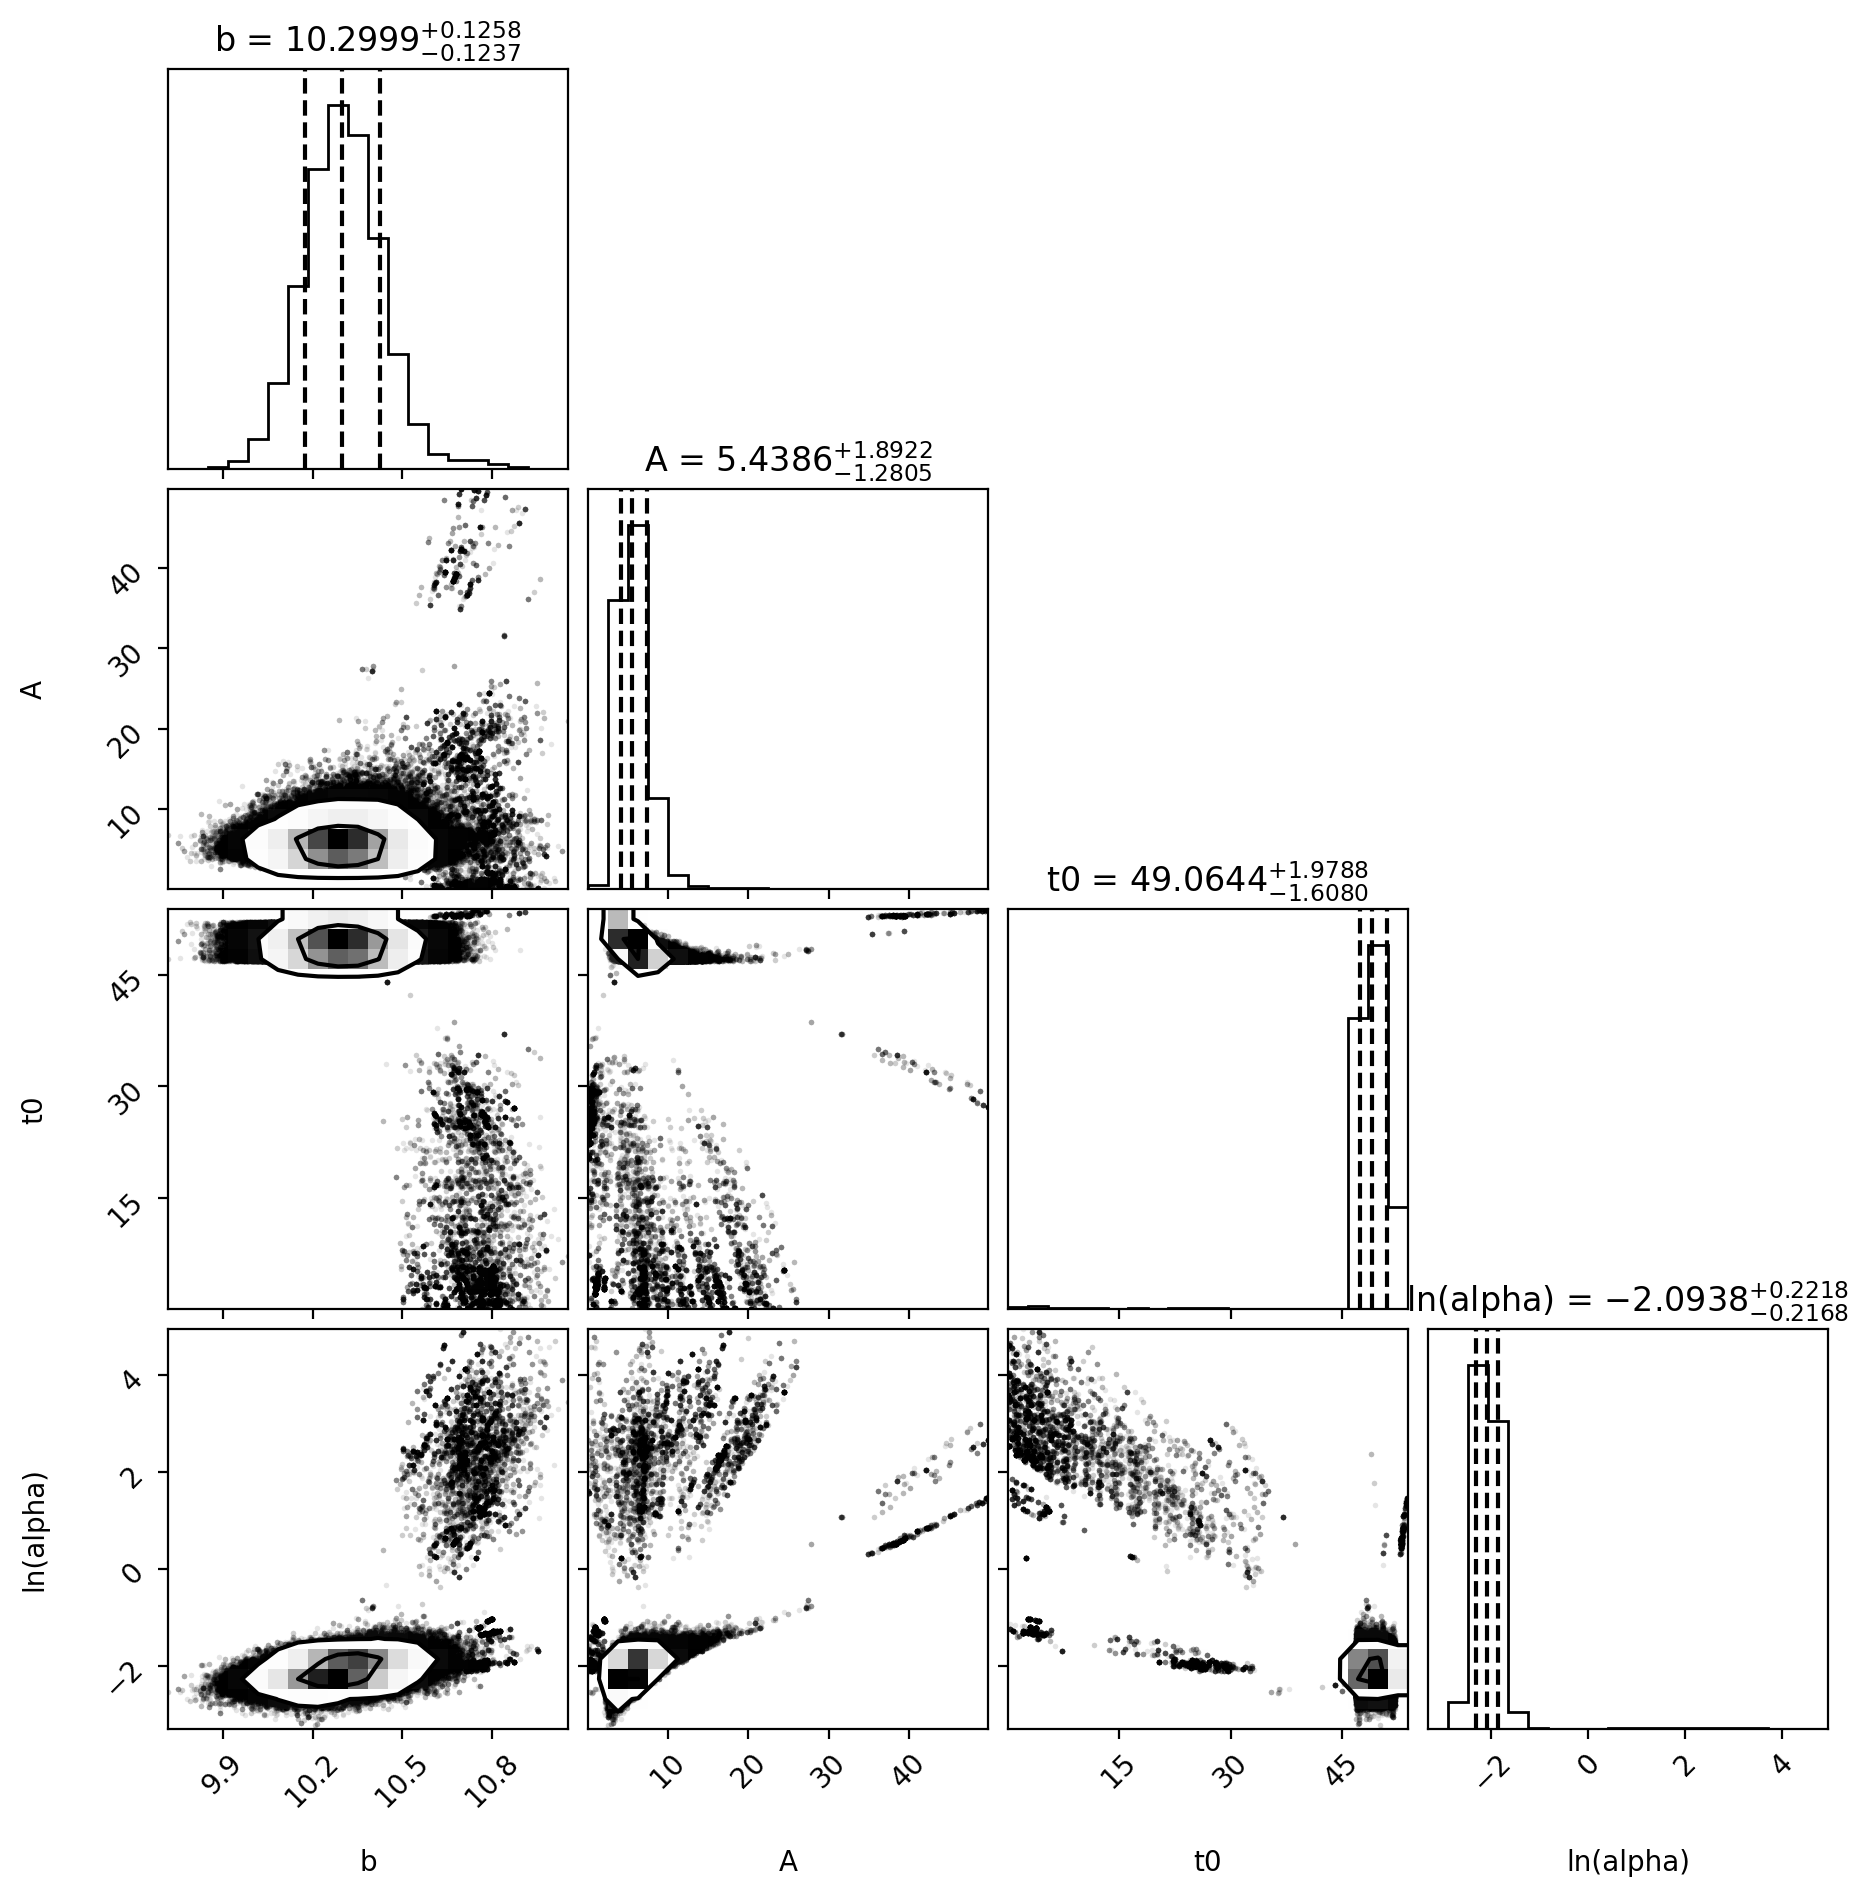

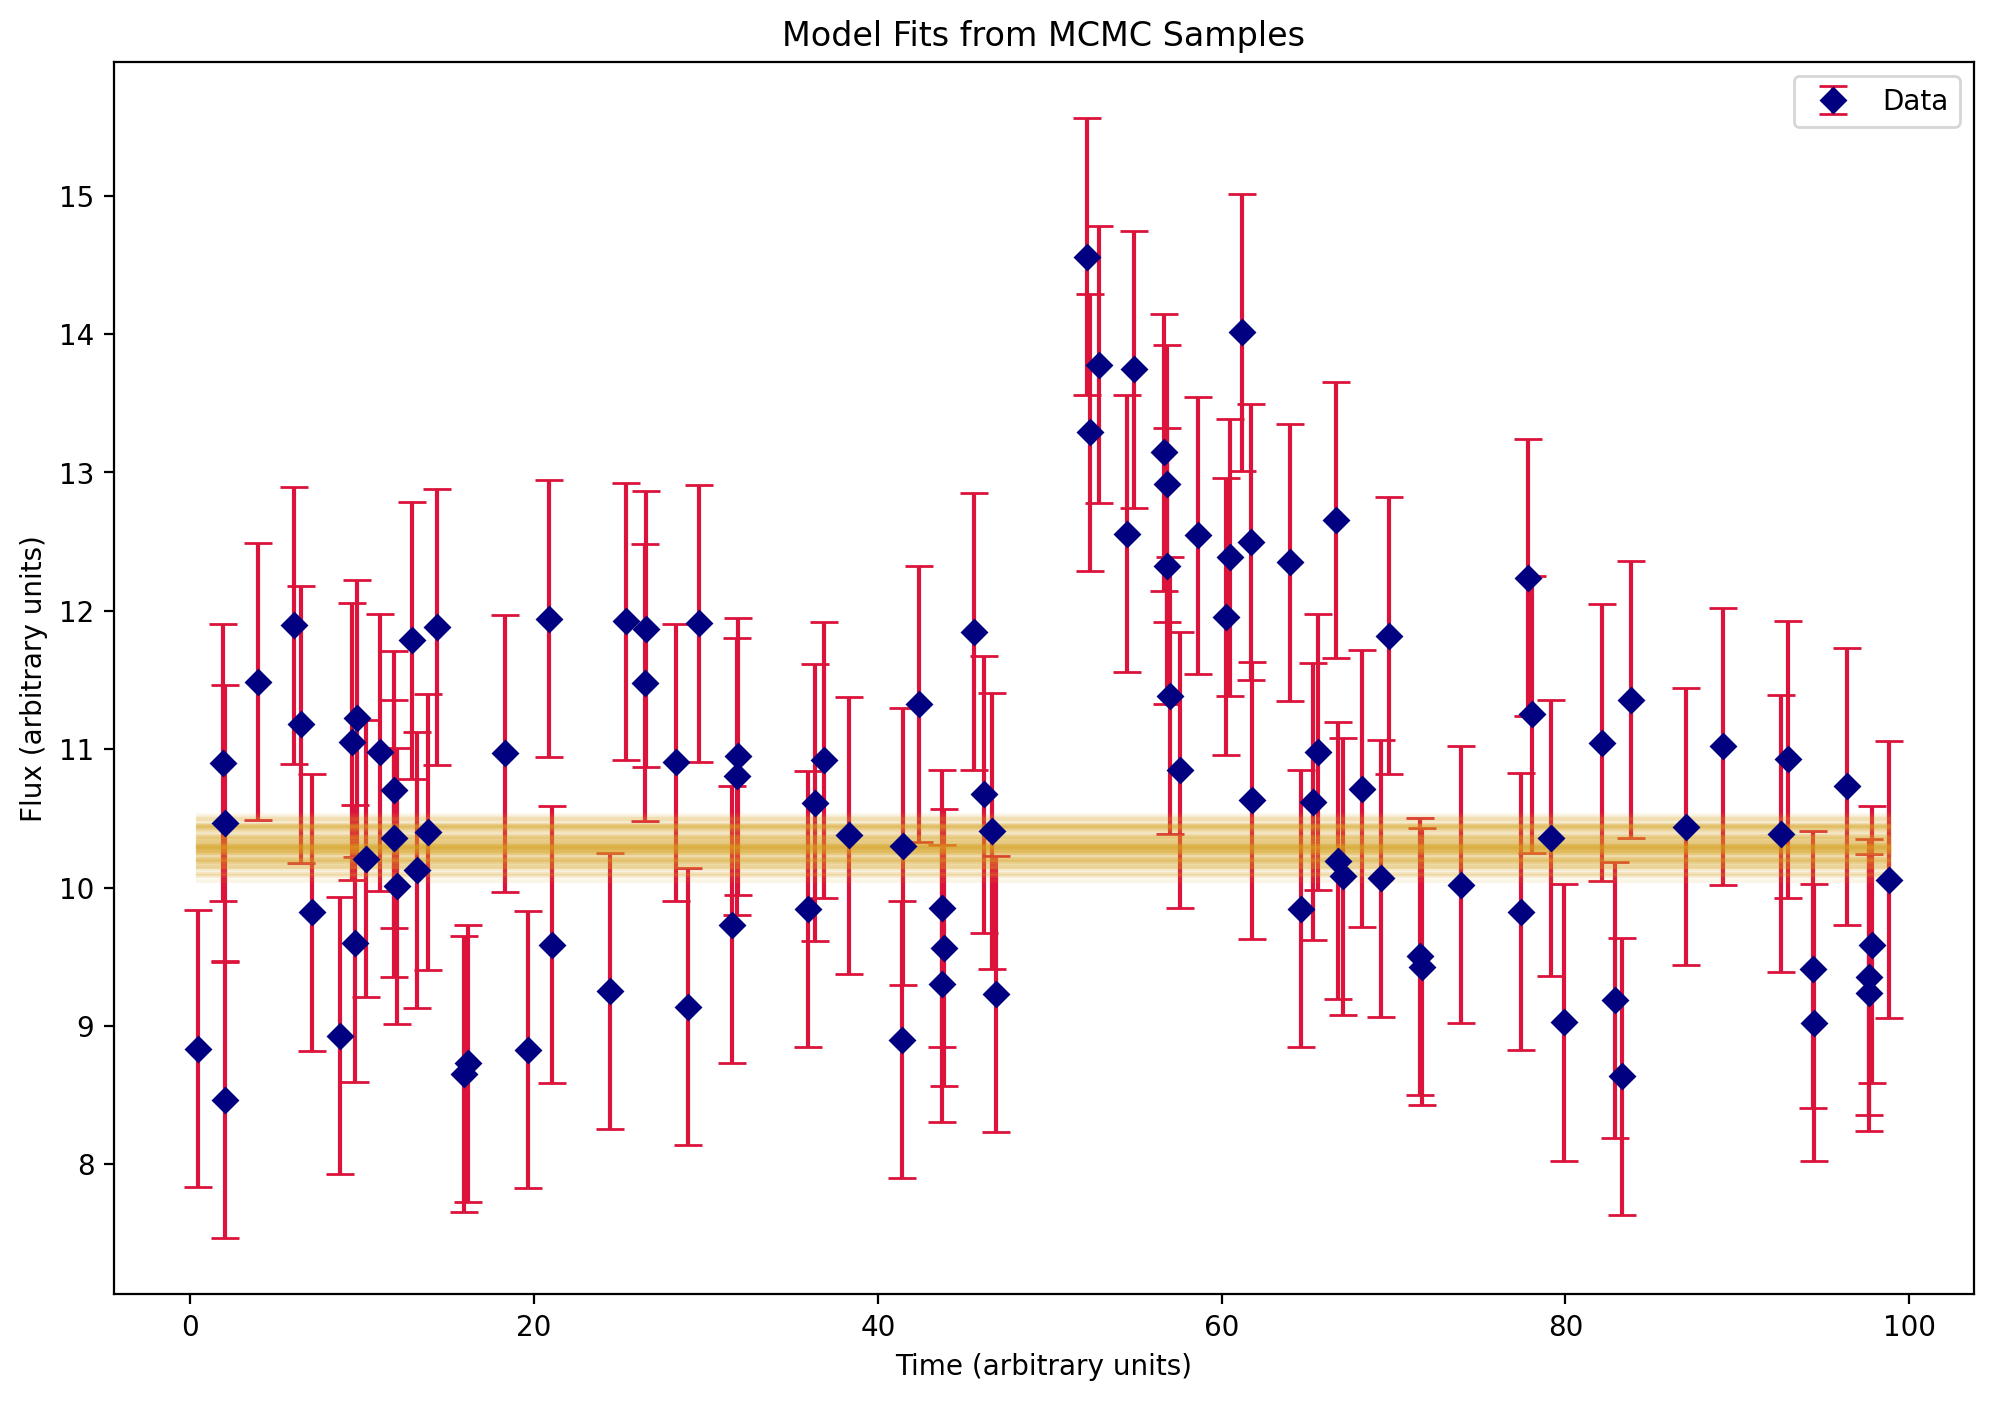

In [38]:
# Plot the posterior distributions
# Plot the corner plot
fig = corner.corner(emcee_trace, labels=['b', 'A', 't0', 'ln(alpha)'], quantiles=[0.16, 0.5, 0.84], 
                     levels=[0.68, 0.95], title_fmt='.4f', show_titles=True)

# Show the plot
plt.show()

# Plot representative model fits
plt.figure(figsize=(12, 8))
plt.errorbar(time, flux, yerr=uncertainties, fmt='D', color='navy', ecolor='crimson', capsize=5, label='Data')
for i in range(100):  # Plot 100 random samples from the chain
    idx = np.random.randint(len(emcee_trace))
    params = emcee_trace[idx]
    model_flux = burst_model(time, *params[:-1], np.exp(params[-1]))
    plt.plot(time, model_flux, color='goldenrod', alpha=0.1)# label = 'Samples from the Chain'
plt.xlabel('Time (arbitrary units)')
plt.ylabel('Flux (arbitrary units)')
plt.title('Model Fits from MCMC Samples')
plt.legend()
plt.show()


SRT: The corner plot looks mostly good, but obviosuly needs to processed further and thinned. The selected samples to plot the curves clearly have some issues, which you fix below.

In [13]:
# Check Burn-in
burnin = 1000
samples_burnin = sampler.get_chain(discard=burnin)

# Reshape the chain for autocorrelation calculation
nsamples, nwalkers, ndim = samples_burnin.shape
samples_burnin_reshaped = samples_burnin.reshape((nsamples * nwalkers, ndim))

# Calculate autocorrelation time
tau = emcee.autocorr.integrated_time(samples_burnin_reshaped)

# Thin the chain
thin_by = int(np.ceil(tau))
samples_thinned = sampler.get_chain(discard=burnin, thin=thin_by, flat=True)

# If the number of samples is small, consider running the MCMC for longer
if len(samples_thinned) < 1000:
    print("Run MCMC for longer.")

# Check the final number of samples
print("Number of samples after thinning:", len(samples_thinned))


Number of samples after thinning: 900000


/var/folders/70/kx5f64q51pxcnd0vjd5s9k480000gp/T/ipykernel_28044/1673606841.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  thin_by = int(np.ceil(tau))


/Users/mcgowkb1/opt/anaconda3/envs/ASTR8070/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


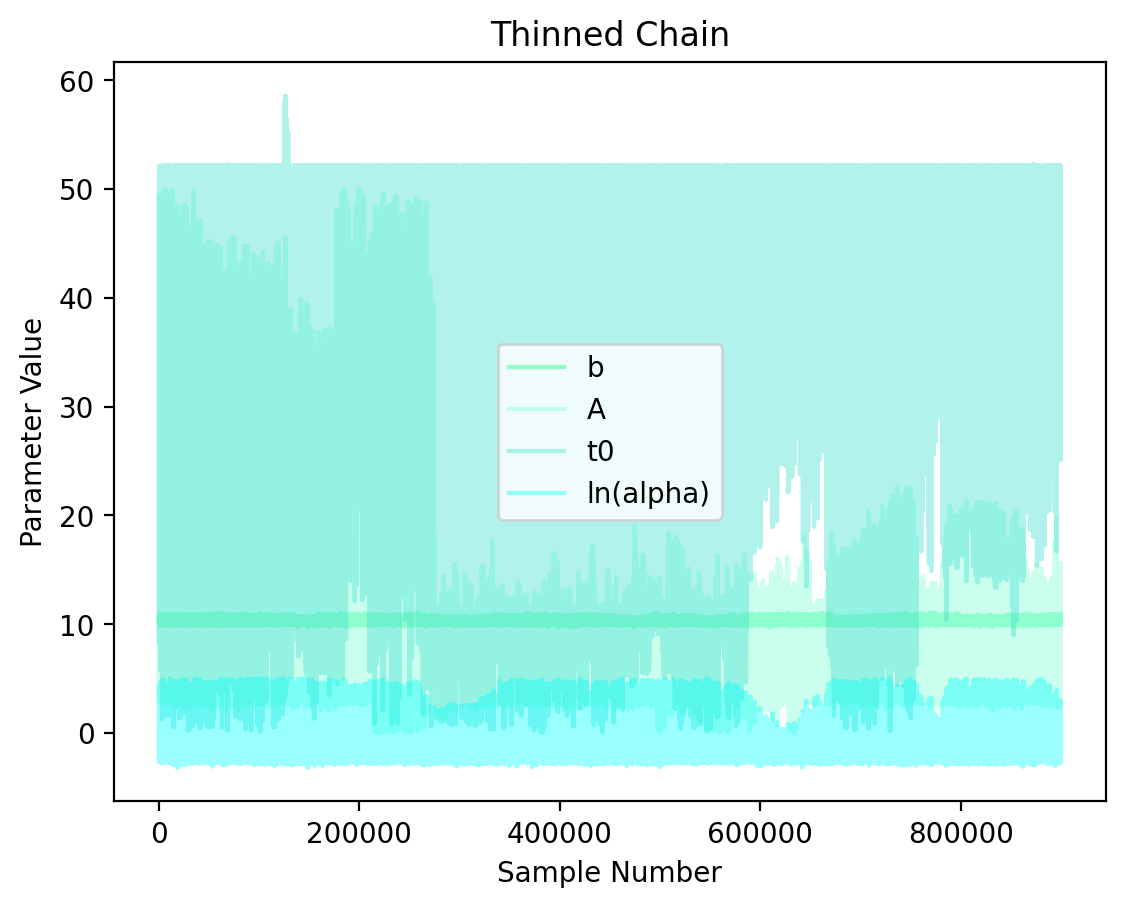

In [33]:

# Plot the autocorrelation time
# plt.figure()
# plt.plot(tau, marker='o')
# plt.xlabel('Parameter')
# plt.ylabel('Autocorrelation Time')
# plt.title('Autocorrelation Time for Each Parameter')
# plt.show()

# Plot the thinned chain
plt.figure()
plt.plot(samples_thinned[:, 0], label='b',color = 'springgreen', alpha = 0.4)
plt.plot(samples_thinned[:, 1], label='A', color ='aquamarine', alpha = 0.4)
plt.plot(samples_thinned[:, 2], label='t0', color ='turquoise' , alpha = 0.4)
plt.plot(samples_thinned[:, 3], label='ln(alpha)',color = 'cyan', alpha = 0.4)
plt.xlabel('Sample Number')
plt.ylabel('Parameter Value')
plt.legend()
plt.title('Thinned Chain')
plt.show()



SRT: This traceplot is very difficult to interpret, Kaylah.

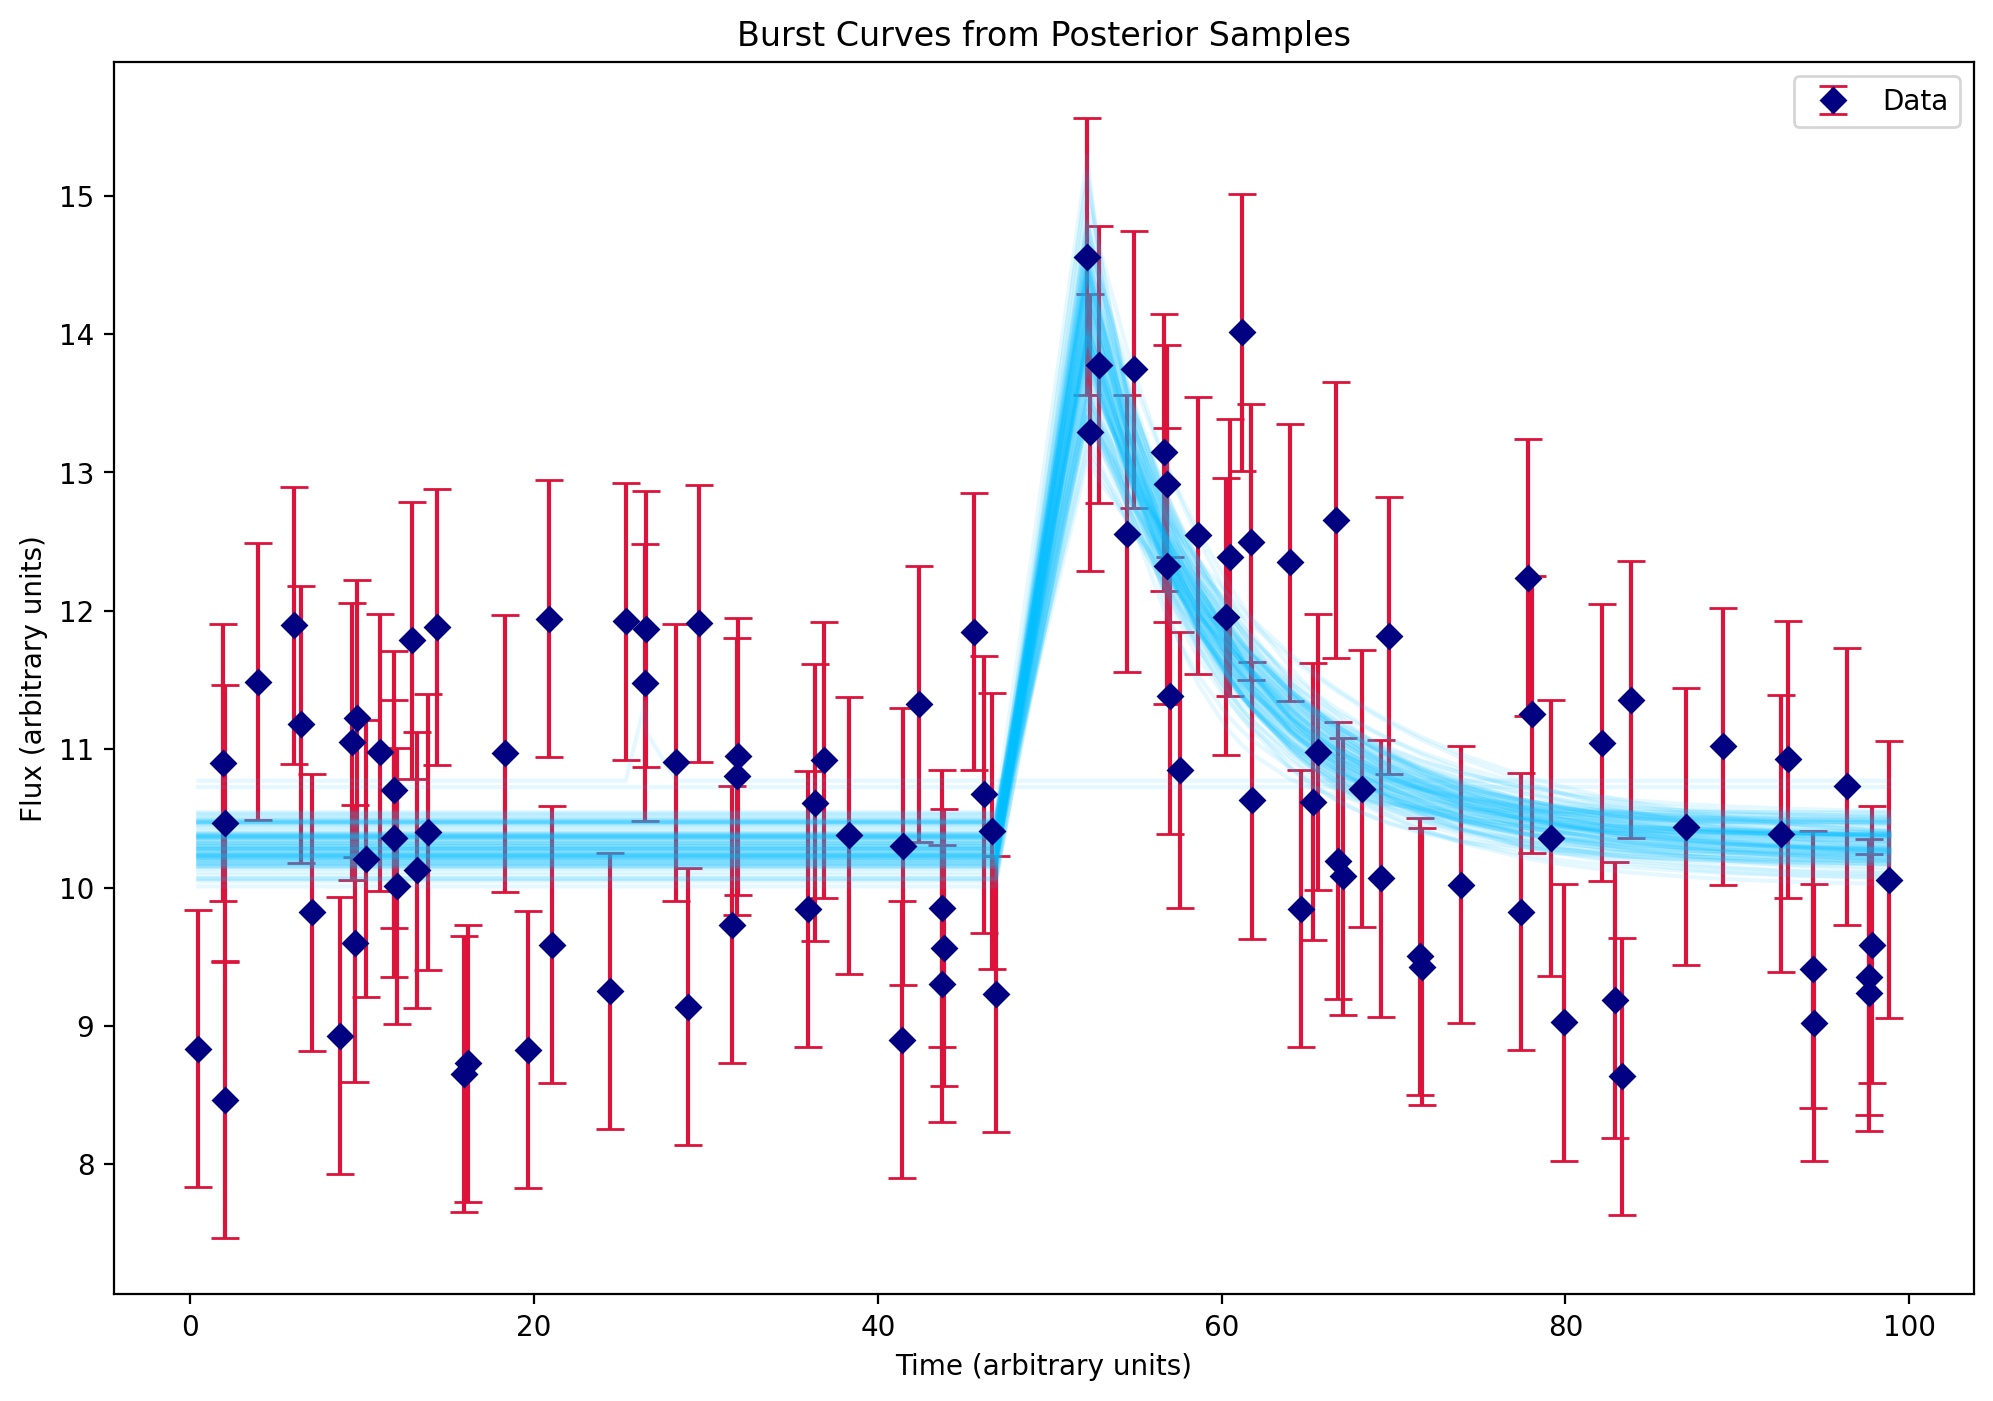

In [39]:
# 100 random samples from the thinned chain
indices = random.sample(range(len(samples_thinned)), 100)
selected_samples = samples_thinned[indices]

# Plot OG data and the burst curves corresponding to the selected samples
plt.figure(figsize=(12, 8))
plt.errorbar(time, flux, yerr=uncertainties, fmt='D', color='navy', ecolor='crimson', capsize=5, label='Data')
for params in selected_samples:
    b, A, t0, ln_alpha = params
    alpha = np.exp(ln_alpha)
    model_flux = burst_model(time, b, A, alpha, t0)
    plt.plot(time, model_flux, color='deepskyblue', alpha=0.1)
plt.xlabel('Time (arbitrary units)')
plt.ylabel('Flux (arbitrary units)')
plt.title('Burst Curves from Posterior Samples')
plt.legend()
plt.show()


SRT: Looks great!

In [51]:
import dynesty


# Define dimensionality of our problem.
ndim = 4  # 4 parameters: b, A, t0, ln(sigma_W)

# Define log likelihood for the Gaussian model.
def log_likelihood_gaussian(params, t, flux, uncertainties):
    b, A, t0, ln_sigma_W = params
    sigma_W = np.exp(ln_sigma_W)
    model_flux = b + A * np.exp(-(t - t0)**2 / (2 * sigma_W**2))
    chi_squared = np.sum(((flux - model_flux) / uncertainties) ** 2)
    return -0.5 * chi_squared

# Define log likelihood for the burst model (from previous MCMC analysis).
def log_likelihood_burst(params, t, flux, uncertainties):
    b, A, t0, ln_alpha = params
    alpha = np.exp(ln_alpha)
    model_flux = burst_model(t, b, A, alpha, t0)
    chi_squared = np.sum(((flux - model_flux) / uncertainties) ** 2)
    return -0.5 * chi_squared

# Define log prior for both models.
def prior_transform(u):
    """Transforms samples `u` drawn from the unit cube to samples from our prior."""

    # For Gaussian model: b, A, t0, ln(sigma_W) in [0, 50], [-50, 50], [0, 100], [-2, 2]
    params_gaussian = [50.0 * u[0], 100.0 * (u[1] - 0.5), 100.0 * u[2], 4.0 * (u[3] - 0.5)]

    # For burst model: b, A, t0, ln(alpha) in [0, 50], [-50, 50], [0, 100], [-5, 5]
    params_burst = [50.0 * u[0], 100.0 * (u[1] - 0.5), 100.0 * u[2], 10.0 * (u[3] - 0.5)]

    return np.array(params_gaussian), np.array(params_burst)
# Define log likelihood for both models.
def log_likelihood_both(params):
    params_gaussian, params_burst = params
    return log_likelihood_gaussian(params_gaussian, time, flux, uncertainties) + \
           log_likelihood_burst(params_burst, time, flux, uncertainties)

# Initialize the sampler
sampler = dynesty.NestedSampler(log_likelihood_both, prior_transform, ndim=ndim)

# Run the sampler for the Gaussian model
sampler.run_nested(nlive_init=100, nlive_batch=100, maxbatch=10)

# Results for the Gaussian model
results_gaussian = sampler.results

# Run the sampler for the burst model
sampler.run_nested(nlive_init=100, nlive_batch=100, maxbatch=10)

# Results for the burst model
results_burst = sampler.results

# Compute the log evidence for each model
log_evidence_gaussian = results_gaussian['logz']
log_evidence_burst = results_burst['logz']

# Compute the Bayes factor
bayes_factor = np.exp(log_evidence_gaussian - log_evidence_burst)

# Print the results
print("Log Evidence (Gaussian):", log_evidence_gaussian)
print("Log Evidence (Burst):", log_evidence_burst)
print("Bayes Factor (Gaussian/Burst):", bayes_factor)


ValueError: could not broadcast input array from shape (500,2,4) into shape (500,4)

SRT: This all looked like it was going really well, Kaylah! Even the fact that both likelihood functions used the negative chi-squared meant that the overall Bayes factor calculation should have given the correct answer. I'm confused though why you made an oveall likelihood function that had both models in there. You needed to compute the evidence of each separately, show corner plots for each model, then compute the Bayes factor. Did you run out of time at the end to attempt to fix the solution? -5 points.